In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Model Deployment for the hedonic dataset 

# 1. Feature Preperation

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/2 FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final_Cleaned.csv'
df = pd.read_csv(file_path)

In [3]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful, reflecting the target variable
df['helpful'] = (df['helpful_vote'] > 0).astype(int)

In [4]:
# Define features and target variable
features = ['RewExt','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE','RatingC']
target = 'helpful'

# Initialize X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer for scaling numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), features)  # Scale numerical features
    ],
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=features)


# 2 Train/Test Split with Stratified K-Fold Cross-validation for Unbalanced Dataset

In [5]:
## Perform stratified K-fold cross-validation for classification with a combined stratification column 'stratify' to ensure balanced class distribution in each fold
# This column is created by combining 'helpful' and 'Prod' columns as strings.
# It uses StratifiedKFold with 10 splits, ensuring each fold preserves the percentage of samples for each class label (product and helpfulness).

from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print shape of the df
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Check the stratify distribution
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))

X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831246
1    0.168754
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.831528
1    0.168472
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify distribution:
 helpful
0    0.831306
1    0.168694
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.830986
1    0.169014
Name: proportion, dtype: float64
X_train shape: (16610, 15)
X_test shape: (1846, 15)
y_train shape: (16610,)
y_test shape: (1846,)
Train stratify di

## 2.1 Data Augmentation 

In the next steps SMOTE is applied to the dataset since it was highly imbalanced, this ensured that the minority class is better represented in the data. 

In [6]:
# Applying SMOTE to the training data to ensure balanced class distribution, increase minority class to 8000 samples

from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# Check the class distribution before resampling
print("Class distribution before SMOTE:")
print(pd.Series(y_train).value_counts())

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())


Class distribution before SMOTE:
helpful
0    13808
1     2803
Name: count, dtype: int64
Class distribution after SMOTE:
helpful
0    13808
1     8000
Name: count, dtype: int64


# 3. Model Building 
The following sections detail the steps for model deployment using Logistic Regression and Gradient Boosting, both applied to the SMOTE-enhanced dataset. For performance evaluation the metrics ACC, F1 and AUC were used.

## 3.1 Logistic Regression

In [7]:
#Using Logistic Regression as Baseline Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='sag', max_iter=1000)  

# Train the model
logreg_model.fit(X_train_balanced, y_train_balanced)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
print("\nLogistic Regression Model Evaluation:")

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
cls_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(cls_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['Logistic Regression'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

LR_results = pd.DataFrame(results_dict)


Logistic Regression Model Evaluation:
Accuracy: 0.816260162601626
F1 Score: 0.4694835680751174
AUC: 0.6831393033365893
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      1534
           1       0.46      0.48      0.47       311

    accuracy                           0.82      1845
   macro avg       0.68      0.68      0.68      1845
weighted avg       0.82      0.82      0.82      1845

Confusion Matrix:
 [[1356  178]
 [ 161  150]]


## 3.2 Random Forest

Exploring other machine learning approaches to evaluate their performance.

In [8]:
# Using Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix

# Initialize the logistic regression model
RF_model = RandomForestClassifier()  

# Train the model
RF_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = RF_model.predict(X_test)


print("\nRandom Forest Model Evaluation:")

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
cls_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(cls_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)




Random Forest Model Evaluation:
Accuracy: 0.8764227642276423
F1 Score: 0.5210084033613446
AUC: 0.6859931582941011
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1534
           1       0.75      0.40      0.52       311

    accuracy                           0.88      1845
   macro avg       0.82      0.69      0.73      1845
weighted avg       0.87      0.88      0.86      1845

Confusion Matrix:
 [[1493   41]
 [ 187  124]]


## 3.2 Extreme Gradient Boosting

For Extreme Gradient Boosting, the first step involved applying the model to the original dataset to demonstrate the improvement in F1 score due to SMOTE. The next step involved deploying the model on the SMOTE-enhanced dataset. Finally, hyperparameter tuning was applied.

In [9]:
# Starting of with unbalanced data (No SMOTE applied) to evaluate improvement due to SMOTE
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault XGBoost Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost Default'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Default_results = pd.DataFrame(results_dict)



Default XGBoost Evaluation:
Accuracy: 0.8720867208672086
F1 Score: 0.5461538461538461
AUC: 0.7064574887753262
Confusion Matrix:
[[1467   67]
 [ 169  142]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1534
           1       0.68      0.46      0.55       311

    accuracy                           0.87      1845
   macro avg       0.79      0.71      0.74      1845
weighted avg       0.86      0.87      0.86      1845

Mean Cross-Validated Accuracy: 0.7905577911634434


In [10]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_SMOTE = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_SMOTE)
conf_matrix = confusion_matrix(y_test, y_pred_SMOTE)
cls_report = classification_report(y_test, y_pred_SMOTE)

print("\SMOTE Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_SMOTE)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_SMOTE)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost SMOTE'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_results = pd.DataFrame(results_dict)

\SMOTE Model Evaluation:
Accuracy: 0.8628726287262872
F1 Score: 0.5645438898450946
AUC: 0.7291153992881607
Confusion Matrix:
[[1428  106]
 [ 147  164]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1534
           1       0.61      0.53      0.56       311

    accuracy                           0.86      1845
   macro avg       0.76      0.73      0.74      1845
weighted avg       0.86      0.86      0.86      1845

Mean Cross-Validated Accuracy: 0.723971803765631


### 3.2.1 XGradBoost Hyperparameter Tuning
In the following hyperparamter tuning is applied to improve the XGBoost model with Bayesian Optimization. 

In [11]:
# import packages for hyperparameters tuning with hyperopt (Bayesian Optimization)

# Define Search Space for hyperparameters
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'gamma': hp.uniform ('gamma', 0,5),
        'reg_lambda' : hp.uniform('reg_lambda', 0,10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3,1),
        'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
        'seed': 0
    }

# Define the objective function, objective function: Takes space as input (hyperparameters to optimize). Returns loss to minimize
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =int(space['n_estimators']), 
                    max_depth = int(space['max_depth']), 
                    gamma = int(space['gamma']),
                    reg_lambda = int(space['reg_lambda']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [12]:
# Running Bayesian Optimization

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.8628726287262872                                     
  1%|          | 1/100 [00:00<00:13,  7.19trial/s, best loss: -0.8628726287262872]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8666666666666667                                                                
SCORE:                                                                            
0.8623306233062331                                                                
  3%|▎         | 3/100 [00:00<00:11,  8.54trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8666666666666667                                                                
SCORE:                                                                            
0.8639566395663957                                                                
SCORE:                                                                            
0.8639566395663957                                                                
  6%|▌         | 6/100 [00:00<00:09,  9.82trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8612466124661247                                                                
SCORE:                                                                            
0.8607046070460704                                                                
SCORE:                                                                            
0.8634146341463415                                                                
  9%|▉         | 9/100 [00:00<00:08, 10.22trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.865040650406504                                                                 
SCORE:                                                                             
0.8644986449864499                                                                 
 11%|█         | 11/100 [00:01<00:08, 10.04trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
SCORE:                                                                             
0.8607046070460704                                                                 
SCORE:                                                                             
0.8639566395663957                                                                 
 14%|█▍        | 14/100 [00:01<00:08,  9.65trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8547425474254743                                                                 
SCORE:                                                                             
0.8531165311653116                                                                 
 15%|█▌        | 15/100 [00:01<00:09,  8.85trial/s, best loss: -0.8666666666666667]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.867750677506775                                                                  
SCORE:                                                                             
0.8579945799457994                                                                
 18%|█▊        | 18/100 [00:01<00:09,  8.43trial/s, best loss: -0.867750677506775]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8536585365853658                                                                
SCORE:                                                                            
0.8601626016260162                                                                
 20%|██        | 20/100 [00:02<00:10,  7.28trial/s, best loss: -0.867750677506775]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8682926829268293                                                                
SCORE:                                                                             
0.8693766937669377                                                                 
SCORE:                                                                             
0.8628726287262872                                                                 
 22%|██▏       | 22/100 [00:02<00:09,  8.03trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8672086720867209                                                                 
SCORE:                                                                             
0.8715447154471545                                                                 
 24%|██▍       | 24/100 [00:02<00:08,  8.93trial/s, best loss: -0.8693766937669377]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
SCORE:                                                                             
0.8688346883468835                                                                 
 27%|██▋       | 27/100 [00:03<00:07,  9.25trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
SCORE:                                                                             
0.8574525745257453                                                                 
 29%|██▉       | 29/100 [00:03<00:07,  9.14trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
SCORE:                                                                             
0.8644986449864499                                                                 
 31%|███       | 31/100 [00:03<00:08,  8.08trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8612466124661247                                                                 
 32%|███▏      | 32/100 [00:03<00:12,  5.29trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8655826558265582                                                                 
 33%|███▎      | 33/100 [00:04<00:17,  3.94trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8682926829268293                                                                 
SCORE:                                                                             
0.8585365853658536                                                                 
 35%|███▌      | 35/100 [00:04<00:13,  4.84trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8710027100271003                                                                 
SCORE:                                                                             
0.8617886178861789                                                                 
 37%|███▋      | 37/100 [00:04<00:10,  6.08trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8617886178861789                                                                 
SCORE:                                                                             
0.8623306233062331                                                                 
SCORE:                                                                             
0.8601626016260162                                                                 
 39%|███▉      | 39/100 [00:05<00:08,  7.17trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8579945799457994                                                                 
 41%|████      | 41/100 [00:05<00:07,  8.05trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8493224932249323                                                                 
SCORE:                                                                             
0.8623306233062331                                                                 
SCORE:                                                                             
0.8612466124661247                                                                 
 44%|████▍     | 44/100 [00:05<00:06,  8.74trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8612466124661247                                                                 
SCORE:                                                                             
0.8644986449864499                                                                 
 46%|████▌     | 46/100 [00:05<00:05, 10.03trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8563685636856369                                                                 
SCORE:                                                                             
0.8607046070460704                                                                 
 48%|████▊     | 48/100 [00:06<00:06,  7.89trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.835230352303523                                                                  
SCORE:                                                                             
0.8644986449864499                                                                 
 50%|█████     | 50/100 [00:06<00:06,  8.00trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
SCORE:                                                                             
0.8612466124661247                                                                 
 52%|█████▏    | 52/100 [00:06<00:06,  7.78trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8682926829268293                                                                 
SCORE:                                                                             
0.8563685636856369                                                                 
 54%|█████▍    | 54/100 [00:06<00:05,  8.29trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8672086720867209                                                                 
SCORE:                                                                             
0.8634146341463415                                                                 
 56%|█████▌    | 56/100 [00:07<00:05,  8.35trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8661246612466125                                                                 
SCORE:                                                                             
0.865040650406504                                                                  
SCORE:                                                                             
0.8639566395663957                                                                 
 59%|█████▉    | 59/100 [00:07<00:05,  7.96trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8596205962059621                                                                 
 59%|█████▉    | 59/100 [00:07<00:05,  7.96trial/s, best loss: -0.8715447154471545]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8726287262872628                                                                 
SCORE:                                                                             
0.8607046070460704                                                                 
 62%|██████▏   | 62/100 [00:07<00:04,  8.67trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8552845528455284                                                                 
SCORE:                                                                             
0.8715447154471545                                                                 
 64%|██████▍   | 64/100 [00:08<00:04,  8.66trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8688346883468835                                                                 
SCORE:                                                                             
0.8699186991869918                                                                 
 66%|██████▌   | 66/100 [00:08<00:04,  7.85trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8682926829268293                                                                 
SCORE:                                                                             
0.8688346883468835                                                                 
 68%|██████▊   | 68/100 [00:08<00:04,  7.21trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8644986449864499                                                                 
SCORE:                                                                             
0.8661246612466125                                                                 
 70%|███████   | 70/100 [00:08<00:03,  8.09trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8644986449864499                                                                 
SCORE:                                                                             
0.8623306233062331                                                                 
SCORE:                                                                             
0.8617886178861789                                                                 
 72%|███████▏  | 72/100 [00:09<00:03,  8.77trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8672086720867209                                                                 
SCORE:                                                                             
0.8655826558265582                                                                 
 75%|███████▌  | 75/100 [00:09<00:02,  9.75trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
SCORE:                                                                             
0.8639566395663957                                                                 
 77%|███████▋  | 77/100 [00:09<00:02,  9.29trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8655826558265582                                                                 
SCORE:                                                                             
0.8585365853658536                                                                 
 79%|███████▉  | 79/100 [00:09<00:02,  7.04trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8601626016260162                                                                 
SCORE:                                                                             
0.8612466124661247                                                                 
 81%|████████  | 81/100 [00:10<00:02,  7.47trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865040650406504                                                                  
 82%|████████▏ | 82/100 [00:10<00:02,  7.39trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8628726287262872                                                                 
SCORE:                                                                             
0.865040650406504                                                                  
 84%|████████▍ | 84/100 [00:10<00:02,  5.98trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8585365853658536                                                                 
SCORE:                                                                             
0.8628726287262872                                                                 
 86%|████████▌ | 86/100 [00:11<00:02,  6.44trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8623306233062331                                                                 
SCORE:                                                                             
0.8655826558265582                                                                 
 88%|████████▊ | 88/100 [00:11<00:01,  6.75trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8639566395663957                                                                 
SCORE:                                                                             
0.867750677506775                                                                  
 90%|█████████ | 90/100 [00:11<00:01,  7.22trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8634146341463415                                                                 
SCORE:                                                                             
0.8536585365853658                                                                 
 92%|█████████▏| 92/100 [00:11<00:01,  7.16trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8579945799457994                                                                 
SCORE:                                                                             
0.8672086720867209                                                                 
 94%|█████████▍| 94/100 [00:12<00:00,  7.87trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8666666666666667                                                                 
SCORE:                                                                             
0.865040650406504                                                                  
 95%|█████████▌| 95/100 [00:12<00:00,  6.49trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.865040650406504                                                                  
SCORE:                                                                             
0.8661246612466125                                                                 
SCORE:                                                                             
0.8666666666666667                                                                 
 98%|█████████▊| 98/100 [00:12<00:00,  7.72trial/s, best loss: -0.8726287262872628]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8672086720867209                                                                 
100%|██████████| 100/100 [00:12<00:00,  7.77trial/s, best loss: -0.8726287262872628]
The best hyperparameters are :  

{'colsample_bytree': 0.4175522500470693, 'gamma': 4.35970416634974, 'max_depth': 18.0, 'min_child_weight': 4.0, 'n_estimators': 450.0, 'reg_lambda': 6.392304230693426}


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [13]:
best_hyperparams = {'colsample_bytree': 0.6294341208375074, 'gamma': 3.3191551562672967, 'max_depth': 15, 'min_child_weight': 2, 'n_estimators': 350, 'reg_lambda': 4.421114602989632}


In [14]:
# With considering inbalanced data applying Weighted XGBoost
# Calculate class distribution

from collections import Counter
sqrt = np.sqrt

# Count the class distribution in the training set
counts = y_train_balanced.value_counts()
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight to ensure class balance
weight_ratio = int(sqrt(count_of_zeros /count_of_ones))

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: helpful
0    13808
1     8000
Name: count, dtype: int64
scale_pos_weight: 1


In [15]:
# Train model with modified hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_opt)
conf_matrix = confusion_matrix(y_test, y_pred_opt)
cls_report = classification_report(y_test, y_pred_opt)

print("\nSMOTE-Hyp Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_opt)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_opt)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)

#Store the results in a dictionary and convert it to a DataFrame
results_dict = {
    'Model': ['XGBoost with Hyperparameters'],
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'AUC': [auc]
}

XGB_Hyp_results = pd.DataFrame(results_dict)


SMOTE-Hyp Model Evaluation:
Accuracy: 0.8737127371273713
F1 Score: 0.5919439579684763
AUC: 0.7420431631151563
Confusion Matrix:
[[1443   91]
 [ 142  169]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1534
           1       0.65      0.54      0.59       311

    accuracy                           0.87      1845
   macro avg       0.78      0.74      0.76      1845
weighted avg       0.87      0.87      0.87      1845

Mean Cross-Validated Accuracy: 0.7105365058407642


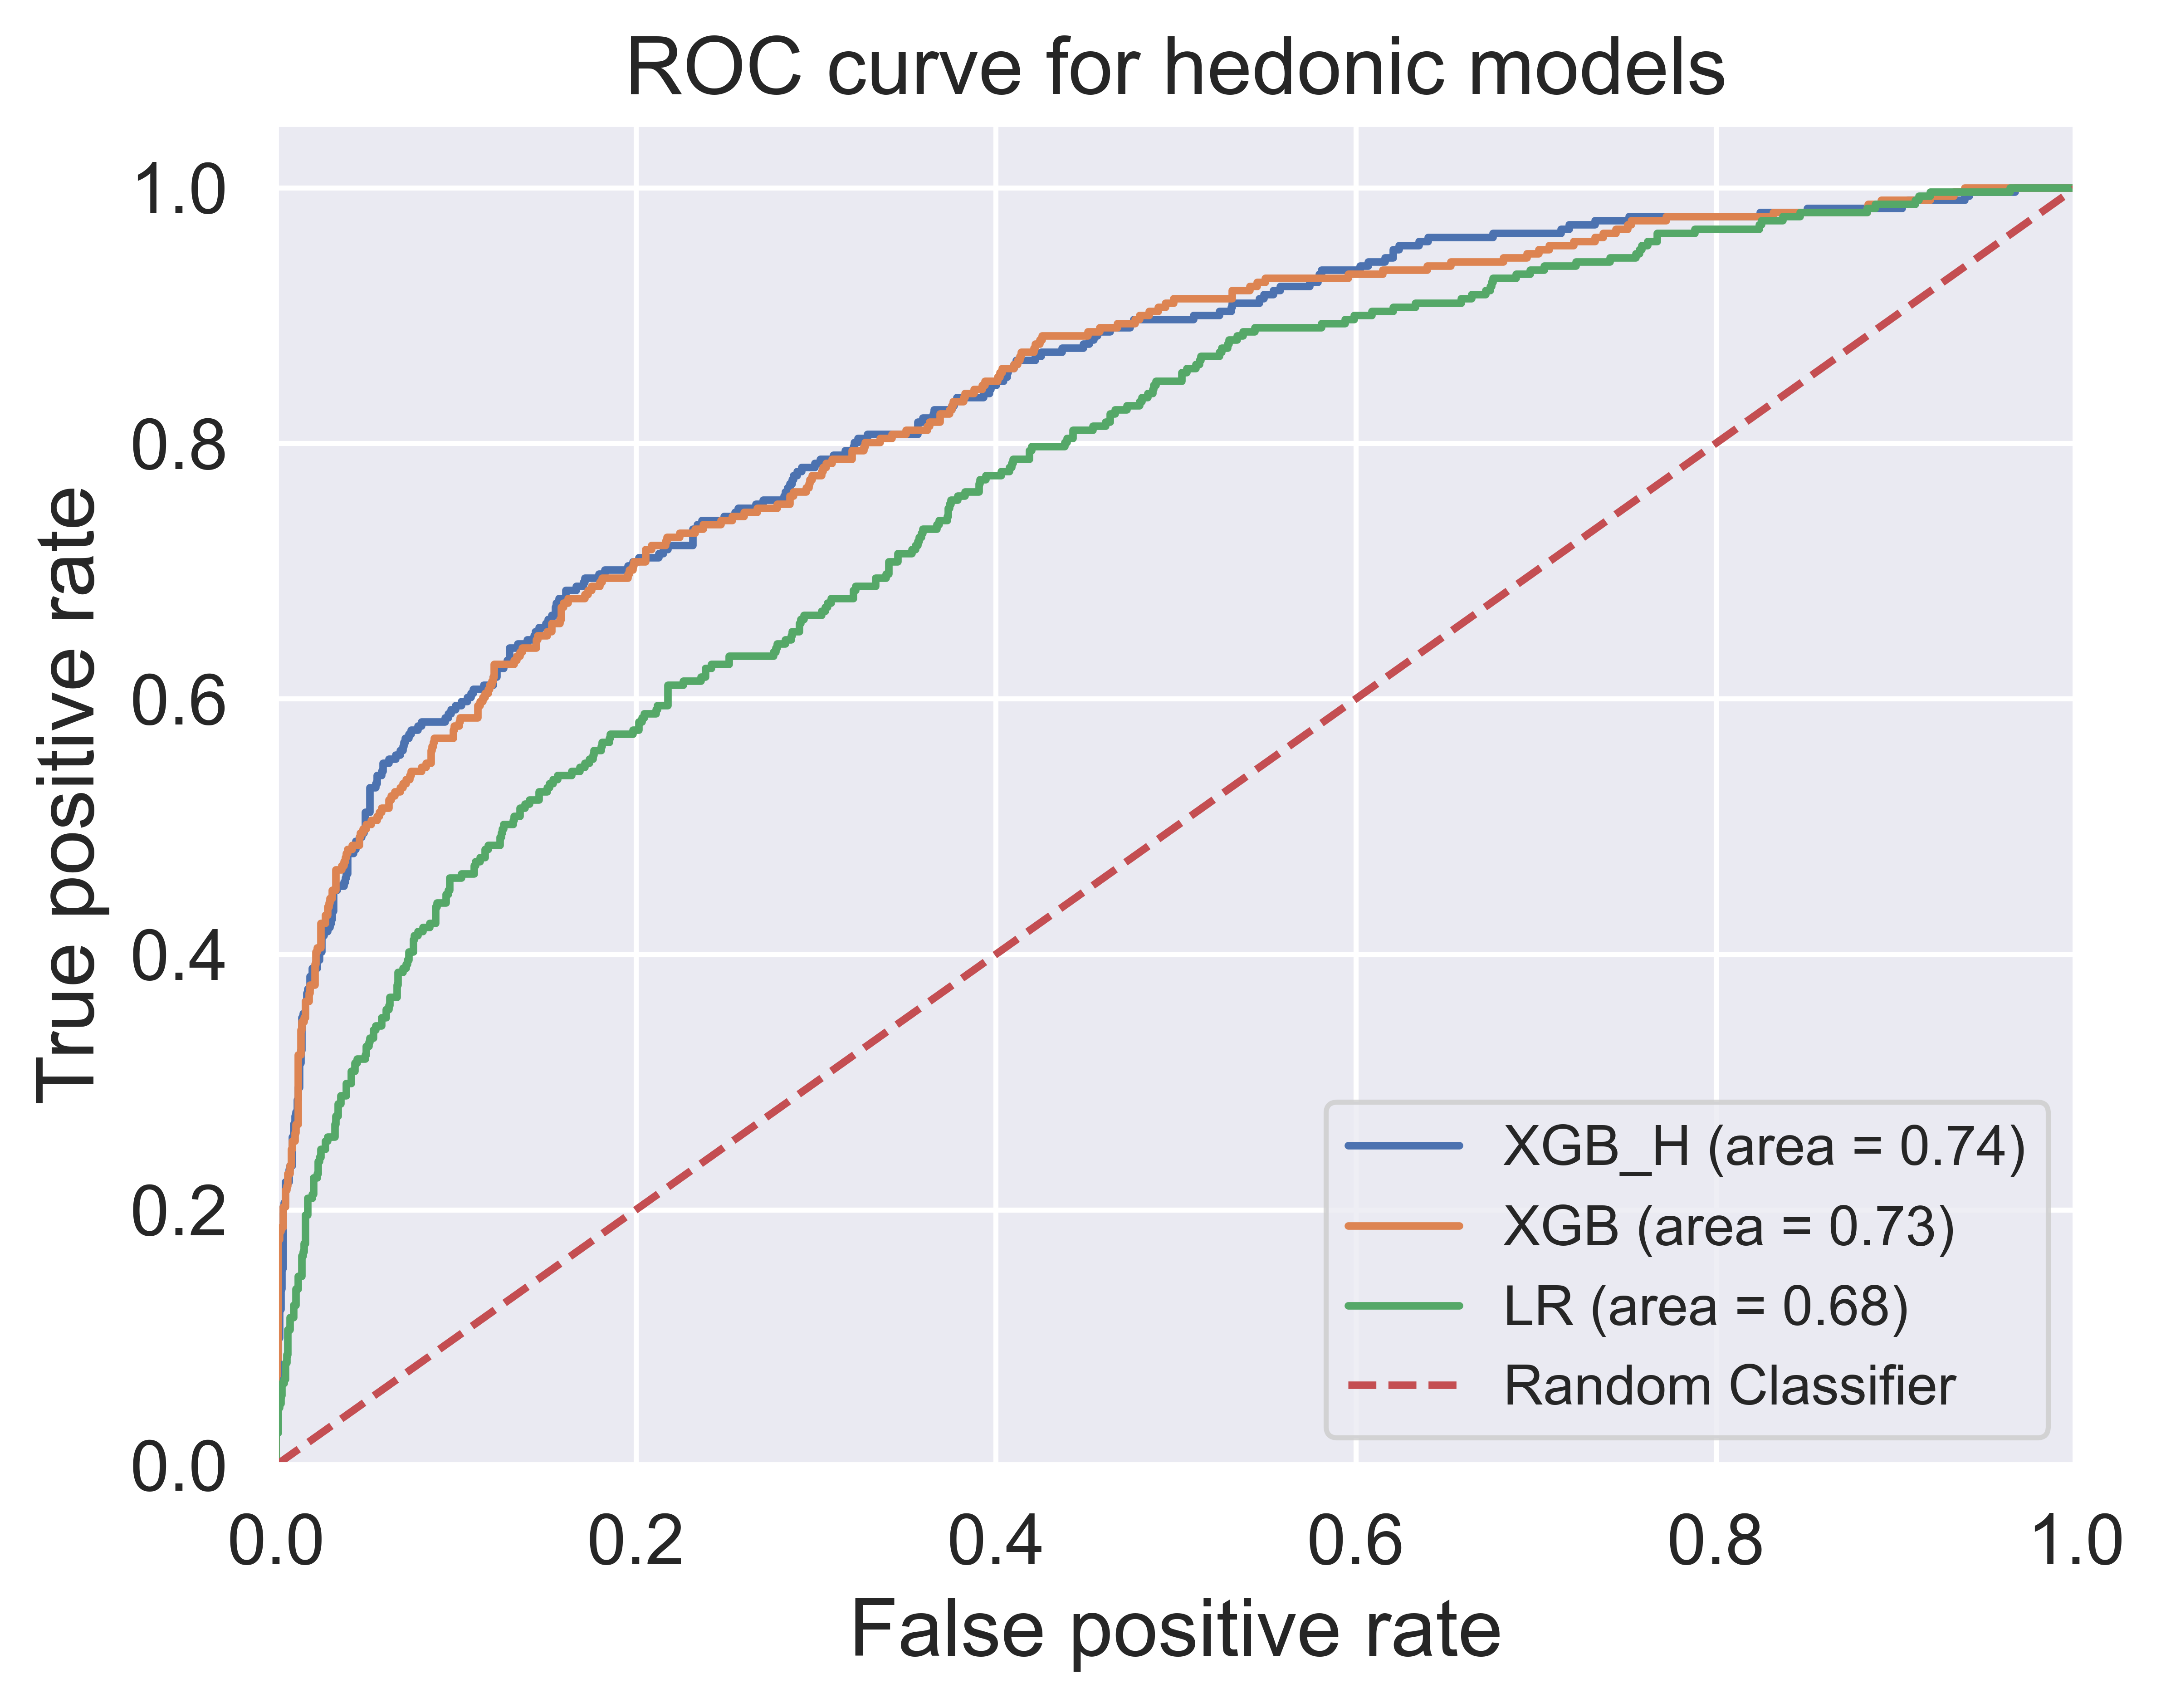

In [34]:
from sklearn.metrics import roc_auc_score, roc_curve


# Calculate ROC AUC and curves for xgb_cls_hyp
logit_roc_auc_hyp = roc_auc_score(y_test, xgb_cls_hyp.predict(X_test))
fpr_hyp, tpr_hyp, thresholds_hyp = roc_curve(y_test, xgb_cls_hyp.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for logreg_model
logit_roc_auc_logreg = roc_auc_score(y_test, logreg_model.predict(X_test))
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, logreg_model.predict_proba(X_test)[:,1])

# Calculate ROC AUC and curves for xgb_cls_SMOTE
logit_roc_auc_smote = roc_auc_score(y_test, xgb_cls_SMOTE.predict(X_test))
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test, xgb_cls_SMOTE.predict_proba(X_test)[:,1])

# Plotting the ROC curves
plt.figure(dpi=800)
plt.plot(fpr_hyp, tpr_hyp, label='XGB_H (area = %0.2f)' % logit_roc_auc_hyp)
plt.plot(fpr_smote, tpr_smote, label='XGB (area = %0.2f)' % logit_roc_auc_smote)
plt.plot(fpr_logreg, tpr_logreg, label='LR (area = %0.2f)' % logit_roc_auc_logreg)
plt.plot([0, 1], [0, 1], 'r--', label='Random Classifier ')

# Setting plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(axis='both', which='major', labelsize=14)  # Increase major tick label size
plt.tick_params(axis='both', which='minor', labelsize=14)  # Increase minor tick label size
plt.xlabel('False positive rate', fontsize=16)
plt.ylabel('True positive rate', fontsize=16)
plt.title('ROC curve for hedonic models', fontsize=16)
plt.legend(loc="lower right")
plt.savefig('ROC_Hedonic.png',dpi=800)
plt.show()


# 4. Model Comparision

In [17]:
results = pd.concat([LR_results, XGB_Default_results, XGB_results, XGB_Hyp_results], axis=0)
print(results)

                          Model  Accuracy  F1 Score       AUC
0           Logistic Regression  0.816260  0.469484  0.683139
0               XGBoost Default  0.872087  0.546154  0.706457
0                 XGBoost SMOTE  0.862873  0.564544  0.729115
0  XGBoost with Hyperparameters  0.873713  0.591944  0.742043




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



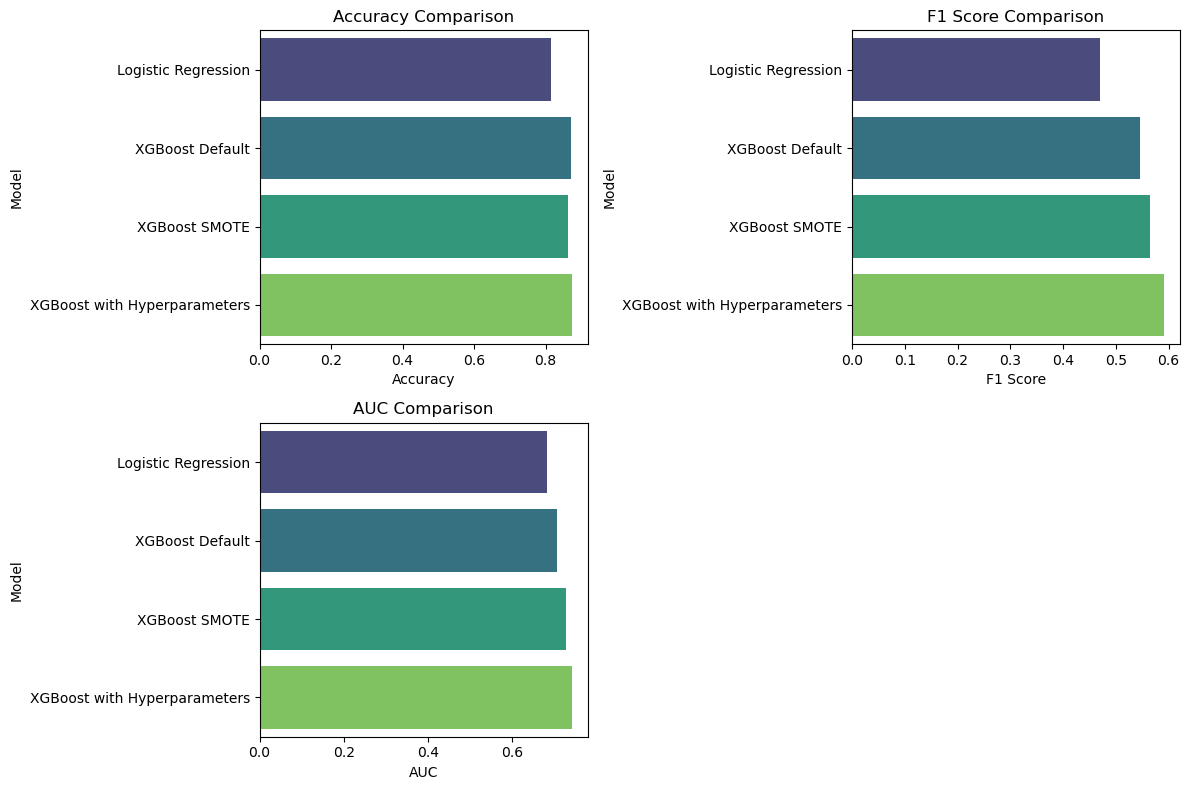

In [18]:
# Plotting the comparison
plt.figure(figsize=(12, 8))

# Plot 1: Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')

# Plot 2: F1 Score
plt.subplot(2, 2, 2)
sns.barplot(x='F1 Score', y='Model', data=results, palette='viridis')
plt.title('F1 Score Comparison')
plt.xlabel('F1 Score')

# Plot 3: AUC
plt.subplot(2, 2, 3)
sns.barplot(x='AUC', y='Model', data=results, palette='viridis')
plt.title('AUC Comparison')
plt.xlabel('AUC')


plt.tight_layout()
plt.show()

# 5. Feature Importance with Shap Values

The next steps include the application of SHAP value analysis for the XGBoost hyperparameter tuned hedonic model. The aim is to evaluate feature importance and compare the features with the features of the utilitarian model. 

[15:37:55] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 21437/21808 [00:28<00:00]        

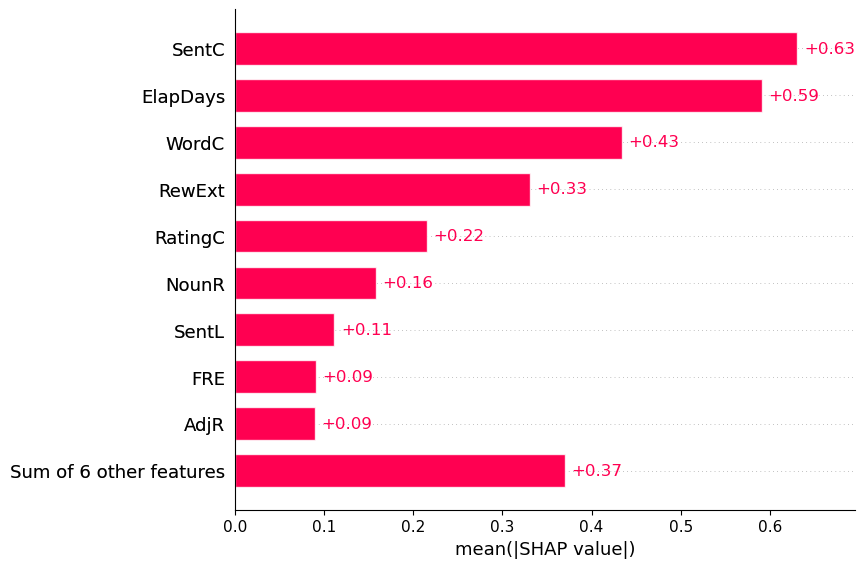

In [19]:
# SHAP values for the best model based on hyperparameter tuned XGBoost Model
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.bar(shap_values.abs.mean(0))


[15:38:23] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 21519/21808 [00:28<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


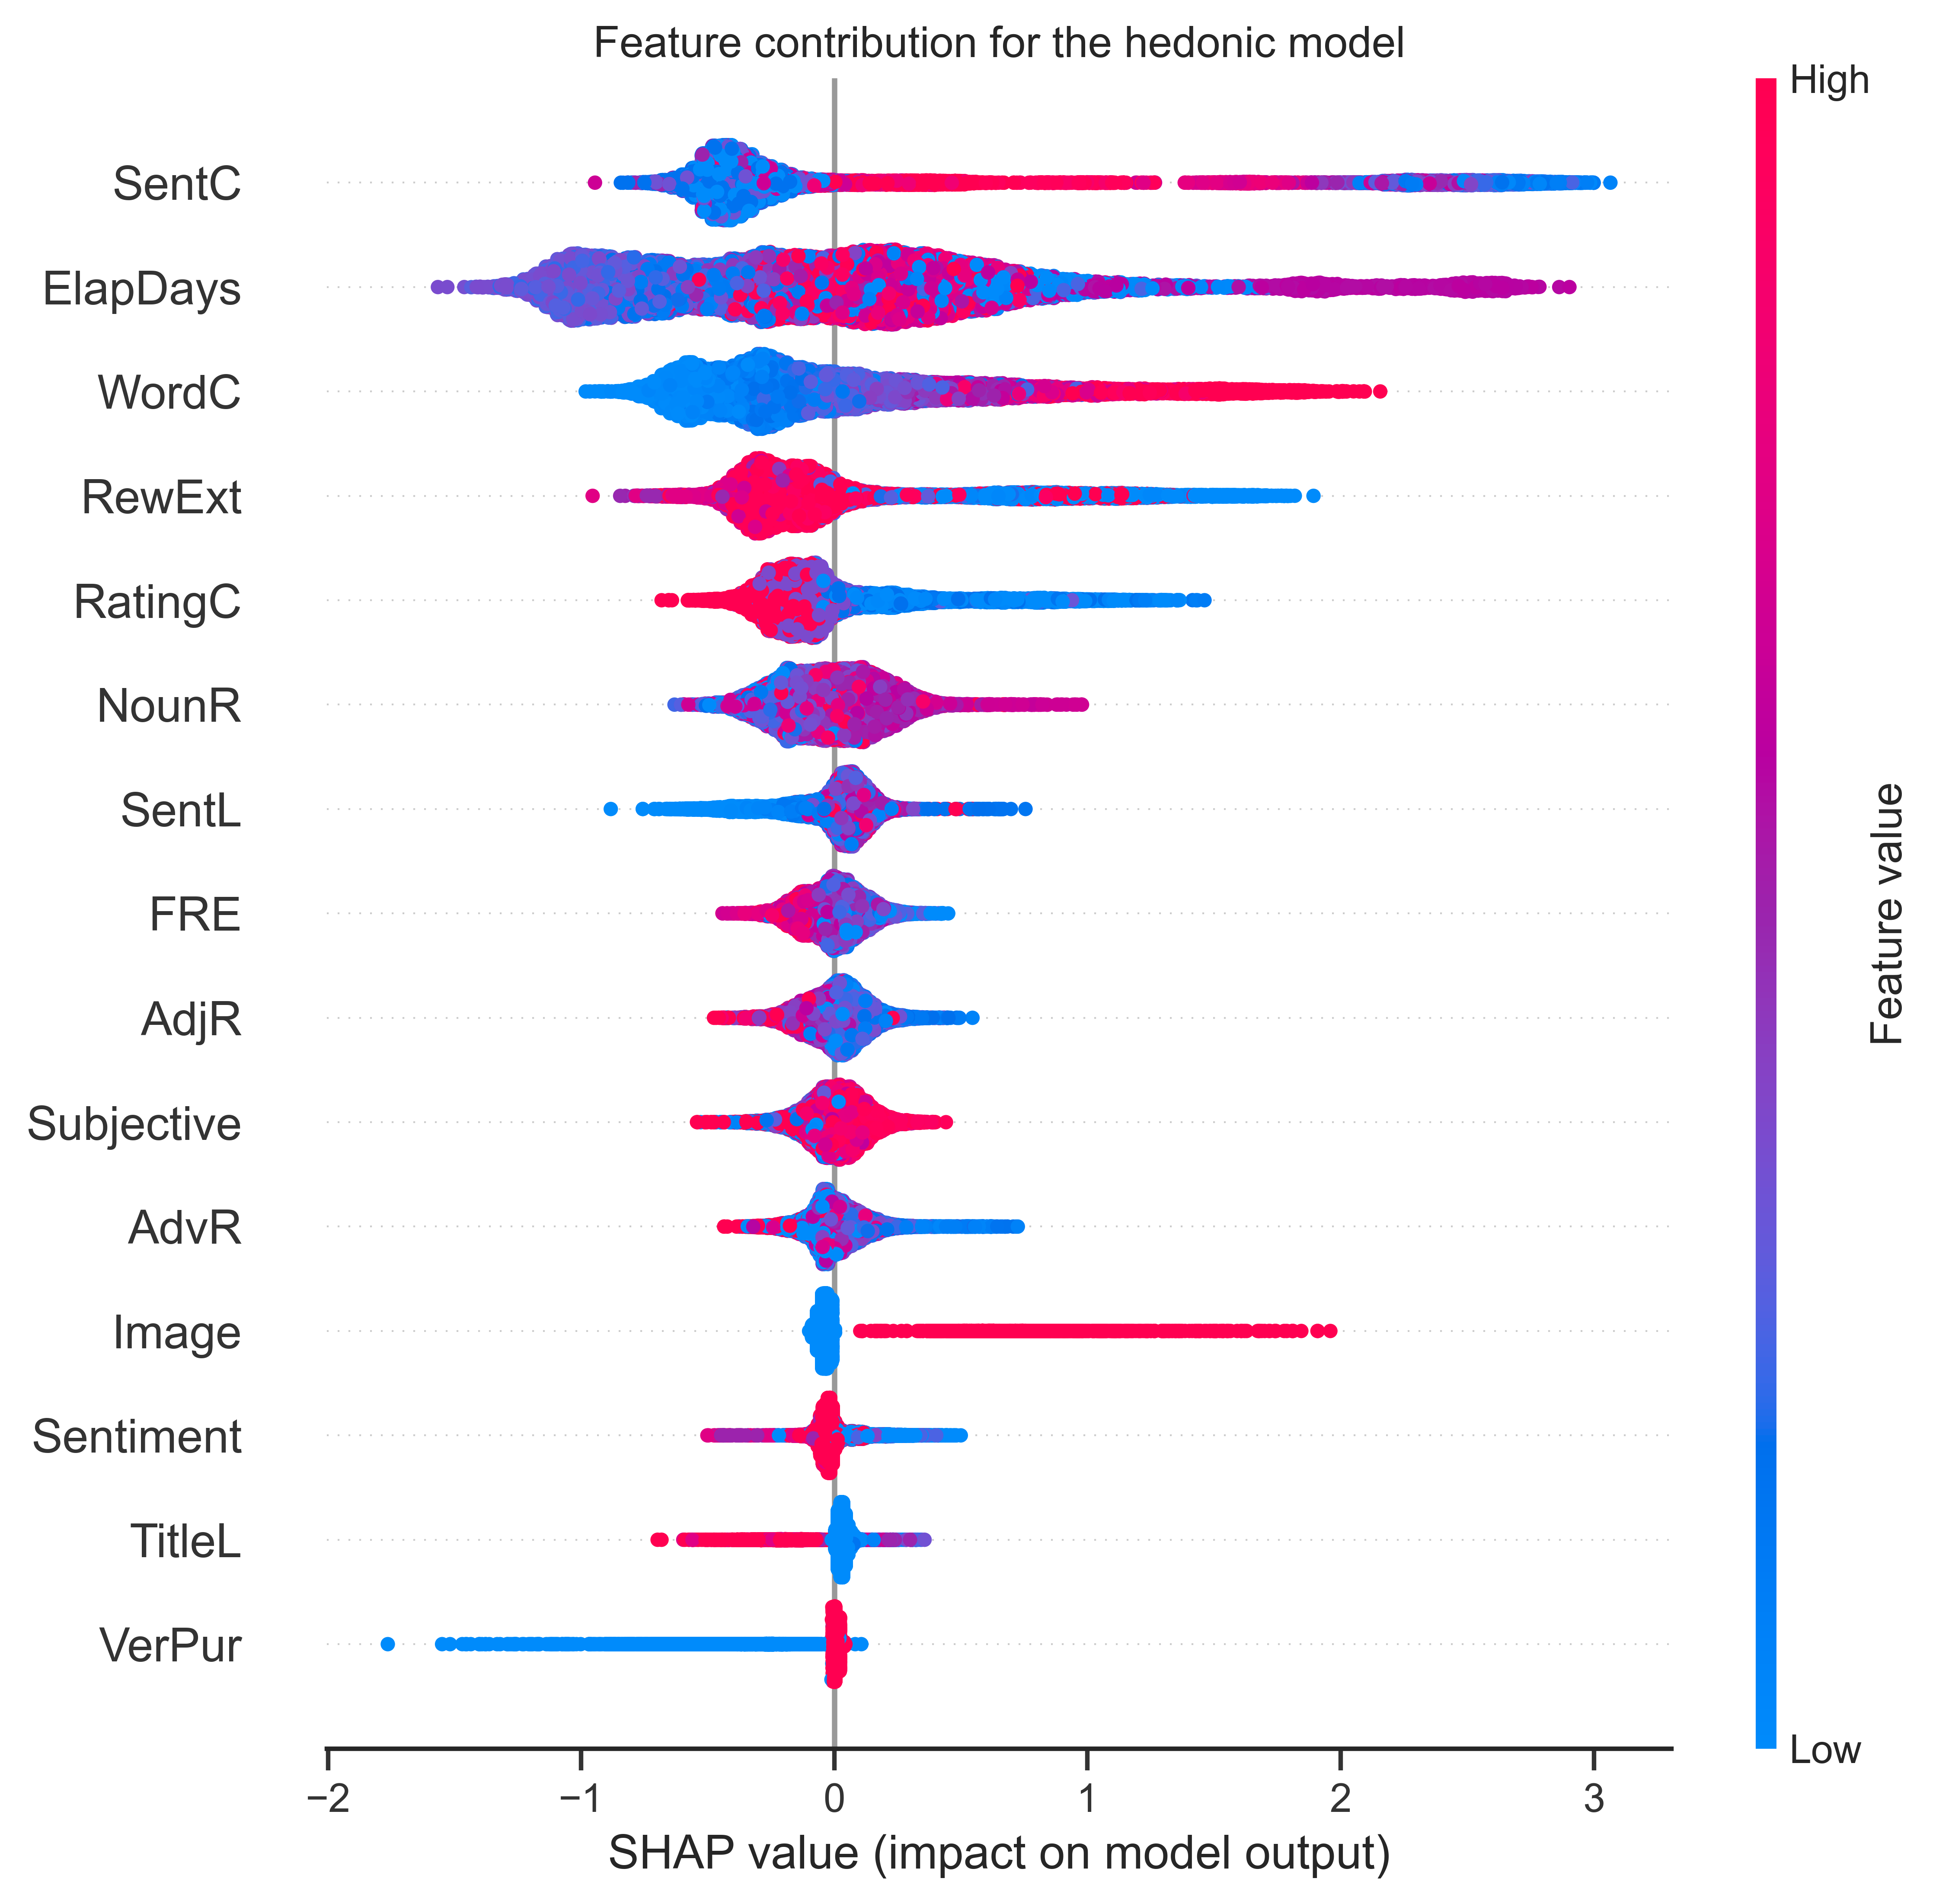

In [20]:
# Create a summary plot
sns.set(style='white')

# Compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

# Create a beeswarm plot with increased quality
fig, ax = plt.subplots(figsize=(6, 8), dpi=600)  # Set figure size and DPI

# Set figure size and DPI
shap.plots.beeswarm(shap_values, max_display=15, show=False)  # Create the plot without displaying it immediately

# Add title to the plot
plt.title('Feature contribution for the hedonic model')

plt.tight_layout()  # Adjust the layout to prevent clipping

# Save the plot to a file with high resolution
#plt.savefig('shap_beeswarm_plot_Hedonic.png', dpi=800)  # Save the figure with the desired DPI

# Display the plot
plt.show()

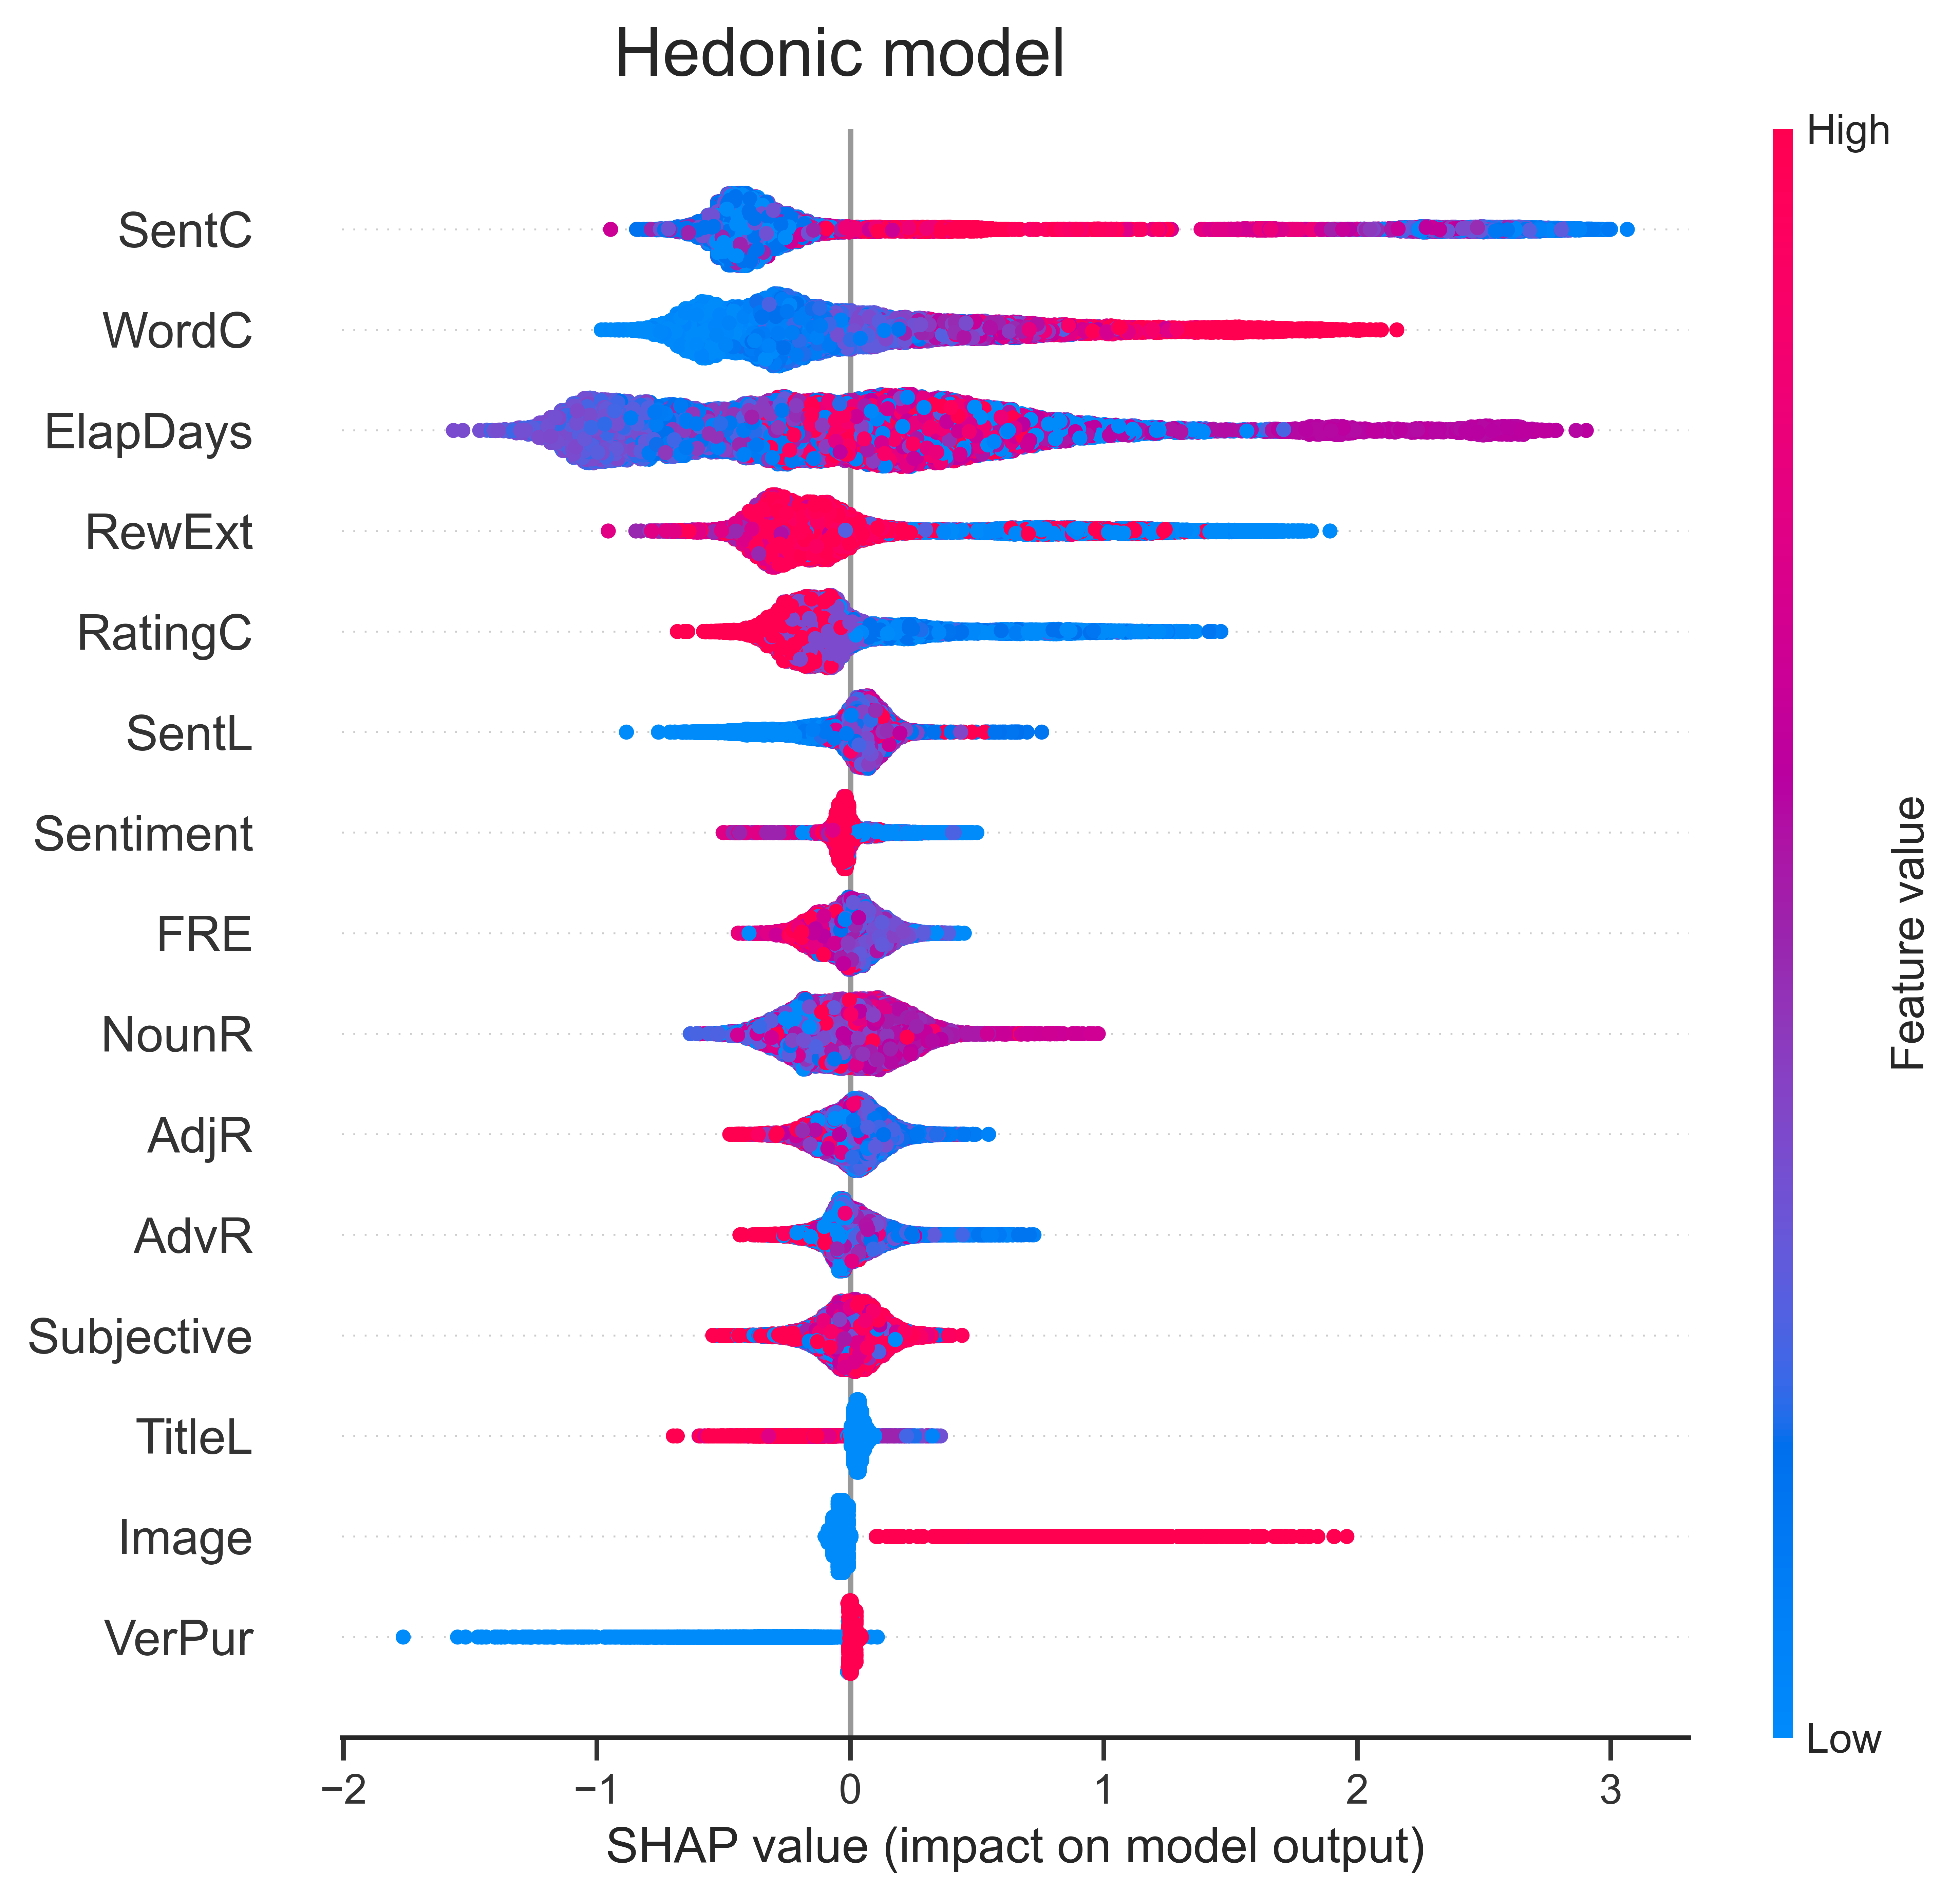

In [21]:
# Define the order of the features for comparision with hedonic feature importance
order = ['SentC','WordC','ElapDays','RewExt','RatingC','SentL','Sentiment', 'FRE','NounR','AdjR', 'AdvR',
         'Subjective','TitleL', 'Image', 'VerPur']

# Create a mapping from column names to their indices
col2num = {col: i for i, col in enumerate(X_train_balanced.columns)}

# Ensure all columns in order exist in the DataFrame and map them to their indices
order = [col2num[col] for col in order if col in col2num]

# Create the beeswarm plot with the correct order
fig, ax = plt.subplots(figsize=(12, 8), dpi=800)  # Set figure size and DPI
shap.plots.beeswarm(shap_values,  max_display=16, show=False, order=order) 


# Add the title above the plot with indentation
plt.suptitle('Hedonic model', fontsize=18, ha='left',  x=0.25, y=0.95)  

# Adjust the layout to create more space at the top for the title
plt.subplots_adjust(top=0.9) 

# Save the plot to a file with high resolution
plt.savefig('shap_beeswarm_plot_Hedonic.png', dpi=600, bbox_inches = "tight")  
plt.show()

[15:39:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


      features  average_shap_value
4        SentC            0.672134
7     ElapDays            0.603569
3        WordC            0.472079
0       RewExt            0.308731
14     RatingC            0.211206
10       NounR            0.143512
5        SentL            0.098468
2   Subjective            0.087515
11        AdjR            0.084024
13         FRE            0.082455
12        AdvR            0.071894
8        Image            0.064421
9       VerPur            0.059130
1    Sentiment            0.056506
6       TitleL            0.034350


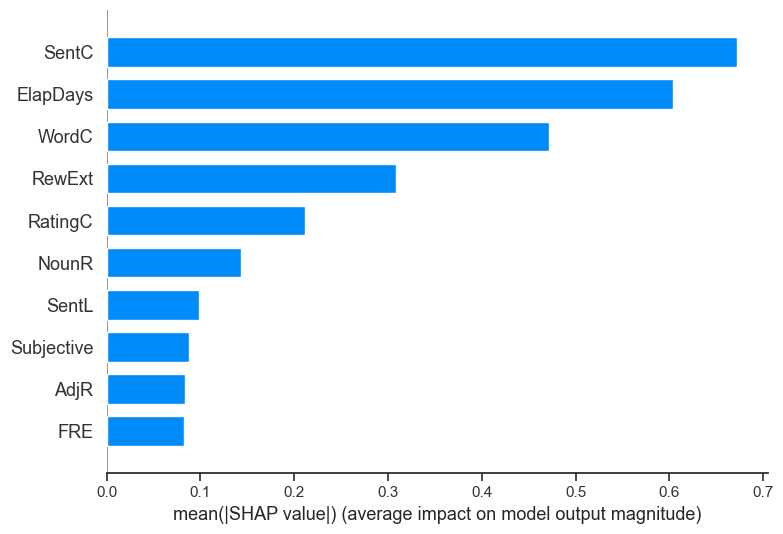

In [22]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)

# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_hedonic = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_hedonic)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True, max_display=10)

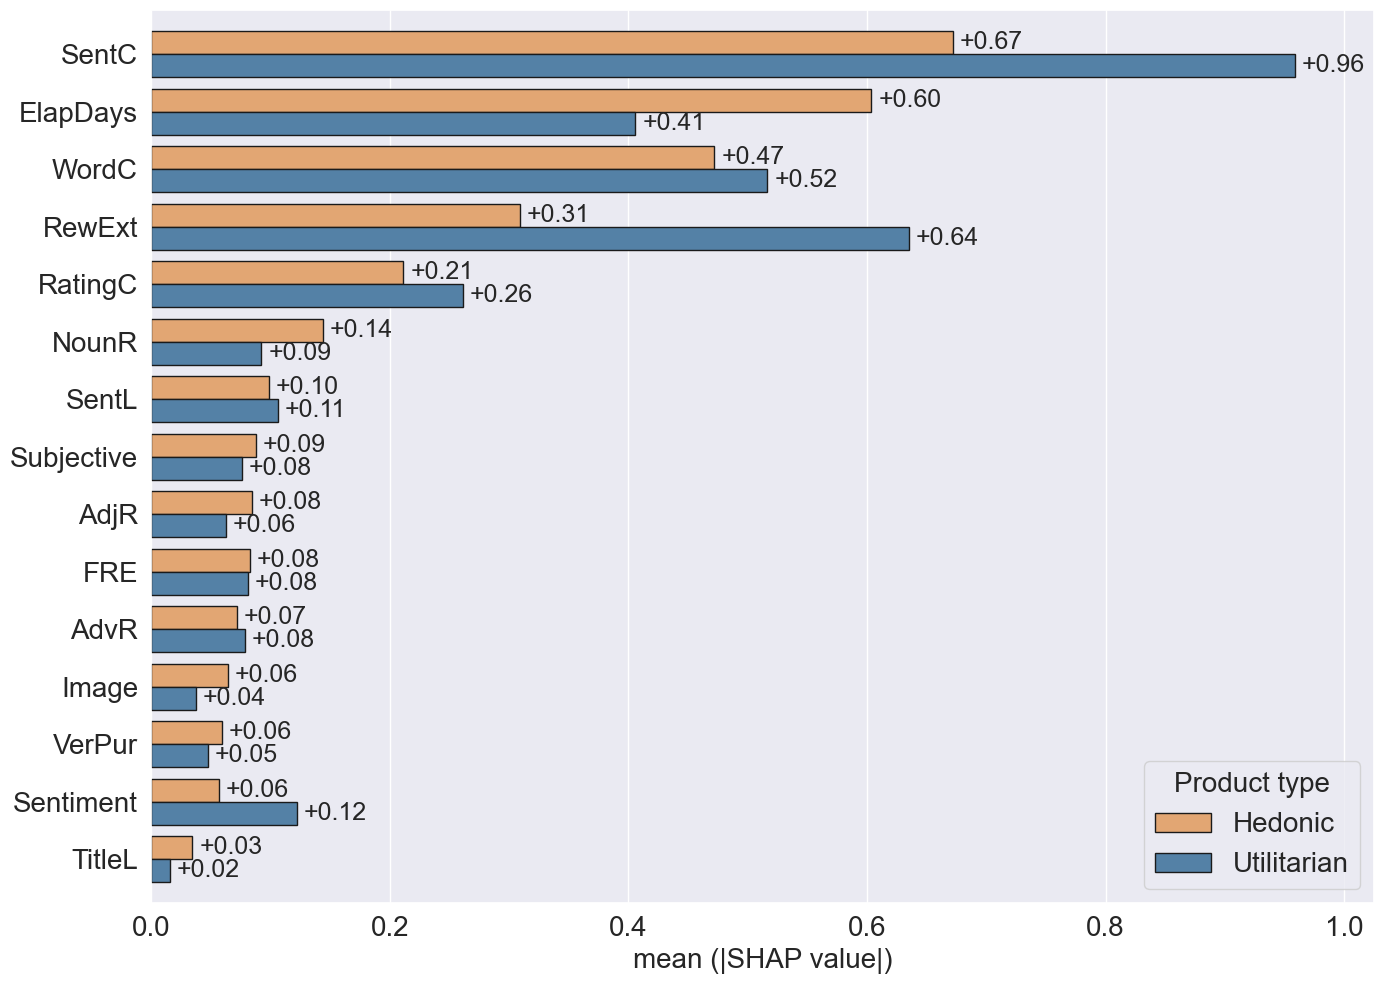

In [30]:
# In the following a comparison mean absolute shap values for the Hedonic and Utilitarian model is shown.

# Importing SHAP Values from utilitarian model
shap_utilitarian = pd.read_csv ("/Users/paulahofmann/Documents/Coding/Online-Review/4 Model Building/shap_values_Utilitarian.csv")

# Add category labels
shap_utilitarian['category'] = 'Utilitarian'
shap_hedonic['category'] = 'Hedonic'

sns.set_theme(style='darkgrid')
# Combine the DataFrames
shap_combined = pd.concat([shap_hedonic, shap_utilitarian])

# Sort by average_shap_value and select top 10 features
top_features = shap_combined.groupby('features')['average_shap_value'].mean().nlargest(16).index
shap_top_combined = shap_combined[shap_combined['features'].isin(top_features)]

# Create the plot
plt.figure(figsize=(14, 10))
ax = sns.barplot(data=shap_top_combined, x='average_shap_value', y='features', hue='category', width=0.8,orient='h', palette={"Utilitarian": "steelblue", "Hedonic": "sandybrown"},ec="k")


# Add the SHAP values beside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='+%.2f', label_type='edge', padding=5, fontsize=18)

# Set x-scale maximum to 0.9
plt.xlim(0, 1.025)

# Set font sizes
plt.xlabel('mean (|SHAP value|)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.relim()
ax.autoscale_view()
ax.margins(y=0.025) 

# Remove y-axis label
plt.ylabel('')
plt.legend(title='Product type', fontsize=20, title_fontsize=20)
plt.tight_layout()
plt.savefig('/Users/paulahofmann/Documents/Coding/Online-Review/4 Model Building/Pictures/Mean_ShapValues.png', dpi=800)  # Save the figure with the desired DPI

plt.show()
